# ML-MotEx with GO

The PDF input for this contains a mixture of tetragonal and octahedral metal centers, but neither works well alone. A smallbox-model with the beta-structure of Gallia works well with a 50%/50% ratio between t- and octahedral coordination, but, the amorphous PDF only extends to ~8 Å. On the other hand, the unit cell extends further.

This ipynb generates a structure catalogue by inputting a supercell of the beta-structure and removing gallium-centers at random. Dangling oxygens are also removed. All structures in the catalogue is then fit against the experimental data (from my PhD work; reach out for details), and the residual is used to train a machine learning algorithm. The machine learning algorithm is in step3+4.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, random
from multiprocessing import Pool
from functools import partial


random.seed(14)
np.random.seed(14)

### functions

In [2]:
# import the fitting function with a generalized way to fit the structure
# fit_structure.py should be edited to the structure input
from fit_structure import fitting
from structure_catalogue import structure_catalogue_maker

In [3]:
def fitting_multiprocess(structure_catalogue, 
                         SaveName, 
                         cores=24 # Ncores to use for fitting.
                        ) -> np.column_stack:
    """
     This function runs the refinement of all the structures in the structure catalogue using multiprocessing
    """
    start_time = time.time()
    values = []
    # Set up multiprocessing refinement
    fitindex = range(len(structure_catalogue))
    p = Pool(processes=cores)
    plot = 0
    func = partial(fitting, starting_model, structure_catalogue, plot, 
                   # non-globals:
                   threshold=threshold, NumMetals=NumMetals, Experimental_Data=Experimental_Data,
                  )
    results = p.map(func, fitindex)
    p.close()
    p.join()
    
    # Start refinement and append results to lists
    for i in fitindex:
        if i % 100 == 0:
            print ("I have now fitted: ", str(i) + " structures out of " + str(len(structure_catalogue)))
        rw = results[i]
        values.append(i)
        values.append(rw)
    values = np.reshape(values,(int(len(values)/2) , 2))
    # Save results in format that is suitable for Machine Learning
    print ("Best fit")
    print (values[np.argmin(values[:,1])])
    print(f"Total execution time: {time.time()-start_time}s")
    Result = np.column_stack([values, np.asarray(structure_catalogue)[values[:,0].astype(int)]])
    np.savetxt(SaveName, Result)
    return Result



# Step 1: Produce a catalogue of structure motifs
### First define the starting model, how large the structure catalogue has to be, number of iterable atoms and threshold between iterable atoms and non-iterable atoms.

In [4]:
starting_model = "Structure_Models/beta-Ga2O3_CollCode83645_1x2x2.xyz" # Name of the starting model file
Number_of_structures = 10000 # Number of structures made to the structure catalogue
NumMetals = 40 # Number of atoms that should be permuted in the starting model
threshold = 2.5 # Thredshold for Ga - O bond


### Produce a catalogue of structure motifs

In [5]:
structure_catalogue = structure_catalogue_maker(Number_of_structures, 
                                                Number_of_atoms=NumMetals, 
                                                lower_atom_number=0, 
                                                higher_atom_number=NumMetals)
#print ("We show the first 5 structures in the catalogue:")
#structure_catalogue[:5]


Starting to make a structure catalogue with: 10000 structure from the starting model.
The structure will have between 0 and 64 atoms
Permutations Succeeded


# Step 2: Fit all of the structures from the catalogue of structure motifs to the dataset
### First define the experimental data path and the path you want the structure catalogue with fits to be saved

In [6]:
Experimental_Data = "Experimental_Data/amorphousFit_Gobs.dat" # Name of the experimental file
saveFits = "Training_Data/structure_go.txt" # Name of the saved fits file


### Produce organized structure catalogue with Rwp values

In [7]:
Result = fitting_multiprocess(structure_catalogue, SaveName=saveFits, cores=None)
print ("The best fitting structure is:")
Result[np.argmin(Result[:,1])]


I have now fitted:  0 structures out of 10000
I have now fitted:  100 structures out of 10000
I have now fitted:  200 structures out of 10000
I have now fitted:  300 structures out of 10000
I have now fitted:  400 structures out of 10000
I have now fitted:  500 structures out of 10000
I have now fitted:  600 structures out of 10000
I have now fitted:  700 structures out of 10000
I have now fitted:  800 structures out of 10000
I have now fitted:  900 structures out of 10000
I have now fitted:  1000 structures out of 10000
I have now fitted:  1100 structures out of 10000
I have now fitted:  1200 structures out of 10000
I have now fitted:  1300 structures out of 10000
I have now fitted:  1400 structures out of 10000
I have now fitted:  1500 structures out of 10000
I have now fitted:  1600 structures out of 10000
I have now fitted:  1700 structures out of 10000
I have now fitted:  1800 structures out of 10000
I have now fitted:  1900 structures out of 10000
I have now fitted:  2000 structu

array([2.38700000e+03, 4.67365929e-01, 2.60000000e+01, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      


# Extra




### We can see that the best fitting structure has 21 atoms as also shown above. This is not the alpha-Keggin cluster which has 12 atoms. However, we can fit this structure to the experimental dataset:

FIT RESULTS
Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       69.54428520
Contributions  69.25915596
Restraints     0.28512924
Chi2           69.25915596
Reduced Chi2   0.07695462
Rw             0.46736590

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
mc          6.22309876e-01 +/- 3.95342164e-02
zoomscale1  9.89843516e-01 +/- 9.85374237e-04
zoomscale2  1.01027958e+00 +/- 9.92112728e-04
zoomscale3  9.89572836e-01 +/- 9.89045429e-04

Fixed Variables
------------------------------------------------------------------------------
Ga_Biso_cluster1  4.00000000e-01
O_Biso_cluster1   4.00000000e-01
delta2_cluster    0.00000000e+00

Variable Correlations greater than 25% (Correlations invalid)
------------------------------------------------------------------------------
No correlations 

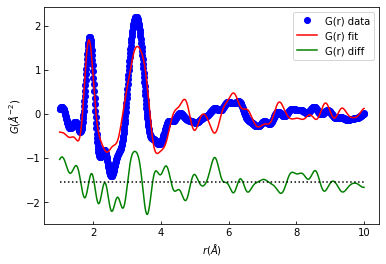

In [8]:
fitting(starting_model, structure_catalogue, plot=True, index=np.argmin(Result[:,1]), 
        threshold=threshold, 
        NumMetals=NumMetals, 
        Experimental_Data=Experimental_Data);

# Visualizing No. Atoms vs. Rwp

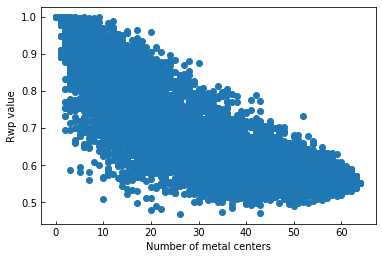

In [9]:
fig, ax = plt.subplots()

ax.plot(Result[:,2], Result[:,1], "o")
ax.set(xlabel="Number of metal centers",
       ylabel="Rwp value"
      )

ax.tick_params(direction='in')


Starting to make a structure catalogue with: 10000 structure from the starting model.
The structure will have between 0 and 80 atoms
Permutations Succeeded
I have now fitted:  0 structures out of 10000
I have now fitted:  100 structures out of 10000
I have now fitted:  200 structures out of 10000
I have now fitted:  300 structures out of 10000
I have now fitted:  400 structures out of 10000
I have now fitted:  500 structures out of 10000
I have now fitted:  600 structures out of 10000
I have now fitted:  700 structures out of 10000
I have now fitted:  800 structures out of 10000
I have now fitted:  900 structures out of 10000
I have now fitted:  1000 structures out of 10000
I have now fitted:  1100 structures out of 10000
I have now fitted:  1200 structures out of 10000
I have now fitted:  1300 structures out of 10000
I have now fitted:  1400 structures out of 10000
I have now fitted:  1500 structures out of 10000
I have now fitted:  1600 structures out of 10000
I have now fitted:  170

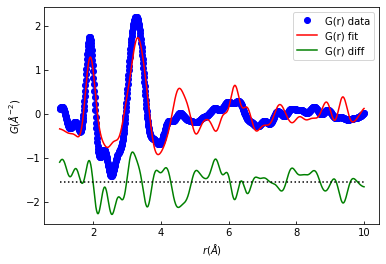

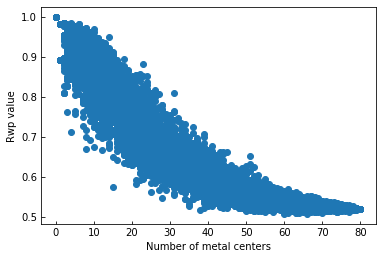

In [12]:
starting_model = "Structure_Models/beta-Ga2O3_CollCode83645_2x2x2.xyz" # Name of the starting model file
Number_of_structures = 10000 # Number of structures made to the structure catalogue
NumMetals = 80 # Number of atoms that should be permuted in the starting model
threshold = 2.5 # Thredshold for Ga - O bond
structure_catalogue = structure_catalogue_maker(Number_of_structures, 
                                                Number_of_atoms=NumMetals, 
                                                lower_atom_number=0, 
                                                higher_atom_number=NumMetals)
#print ("We show the first 5 structures in the catalogue:")
#structure_catalogue[:5]

Experimental_Data = "Experimental_Data/amorphousFit_Gobs.dat" # Name of the experimental file
saveFits = "Training_Data/structure_go.txt" # Name of the saved fits file
Result = fitting_multiprocess(structure_catalogue, SaveName=saveFits, cores=None)
print ("The best fitting structure is:")
Result[np.argmin(Result[:,1])]
fitting(starting_model, structure_catalogue, plot=True, index=np.argmin(Result[:,1]), 
        threshold=threshold, 
        NumMetals=NumMetals, 
        Experimental_Data=Experimental_Data);

fig, ax = plt.subplots()

ax.plot(Result[:,2], Result[:,1], "o")
ax.set(xlabel="Number of metal centers",
       ylabel="Rwp value"
      )

ax.tick_params(direction='in')
